# PageRank Implementation and Intuition

## History of Page Rank
"Larry Page and Sergey Brin developed PageRank at Stanford University in 1996 as part of a research project about a new kind of search engine. An interview with Hector Garcia-Molina: Stanford Computer Science Professor and Advisor to Sergey [21] provides background into the development of the page-rank algorithm. [22] Sergey Brin had the idea that information on the web could be ordered in a hierarchy by "link popularity": a page ranks higher as there are more links to it.[23] The system was developed with the help of Scott Hassan and Alan Steremberg, both of whom were cited by Page and Brin as being critical to the development of Google.[6] Rajeev Motwani and Terry Winograd co-authored with Page and Brin the first paper about the project, describing PageRank and the initial prototype of the Google search engine, published in 1998.[6] Shortly after, Page and Brin founded Google Inc., the company behind the Google search engine. While just one of many factors that determine the ranking of Google search results, PageRank continues to provide the basis for all of Google's web-search tools.[24]" - https://en.wikipedia.org/wiki/PageRank#History

## Implementation Notes
* Use an adjanceny list instead of a adjancency matrix because of the sparcity of links
* No self links
* All multiple links between page A and B become a single link
* Portions of the intuition of this lecture comes from https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html

## Overview of algorithm
PageRank does not take into a user's query. It is based soley on the links between webpages. We can think of PageRank as a measure of how likely someone is to naturally stumble across webpage A. If a lot of other webpages link to A, then A is more "important".

We also want to capture the idea that is webpage A is important and A links to B, then B is also probably important. It shares some of the importance that was measured for A.

### Example graph 1
Simple graph where A is the most important node. PageRank starts by giving each webpage (node) a score of 1/N, where N is the number of nodes (webpages) in the graph.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import networkx as nx
import pandas as pd

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


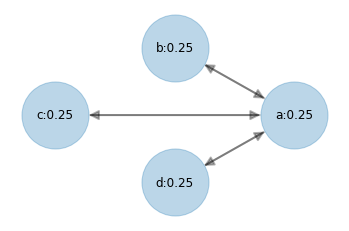

In [2]:
N = 4 # a,b,c,d ... example includes 4 webpages

# We are using networkx directed graph. 
G = nx.DiGraph()

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')

def plot(G):
    pos = nx.circular_layout(G)  # positions for all nodes

    node_size=4500

    # labels
    labels=dict((n,"%s:%.2f"%(n,d['score'])) for n,d in G.nodes(data=True))
    #nx.draw_networkx_labels(G, pos, labels=labels, font_size=20, font_family='sans-serif')

    nx.draw_networkx_edges(G, pos=pos, with_labels=True, node_size=node_size, alpha=0.3, arrows=True,
            arrowsize=20, width=2)
    # draw white circles over the lines
    nx.draw_networkx_nodes(G, pos=pos, with_labels=True, node_size=node_size, alpha=1, arrows=True,
            arrowsize=20, width=2, node_color='w')
    # draw the nodes as desired
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, alpha=.3, arrows=True,
            arrowsize=20, width=2)
    nx.draw_networkx_labels(G, labels=labels,pos=pos)

    plt.axis('off')
    plt.show()
plot(G)

Next, we will take the old page rank for every webpage and equally share it with every web page it links to.

That is, we loop through each vertex (each webpage) and increase the new rank for every adjacent vertex by the following amount:
$$
d*\frac{\mbox{old page rank}}{\mbox{number of unique links}}
$$
Here, $d$ is the "decay" factor: it's a parameter that represents the rate at which your surfers are willing to "continue clicking" a link. We usually set $d$ equal to roughly 0.85. This means that about 85% of your users will be willing to continue visiting new web pages. The other 15% simply stop where they are.

This decay factor also helps our page ranks converge: they ensure that every time we run the update step, our page ranks change less and less. Note that the closer we set $d$ to 0, the faster we converge (but the more inaccurate are results are likely to be).

If the web page has no links, we assume those visitors jump to a random webpage. That is, if the current page has no outgoing links, increase the new page rank of every webpage by:
$$
d*\frac{\mbox{old page rank}}{N}
$$

One final step: We need to add $(1-d)/N$ to every webpage's new page rank. The technical reason we do this is to make sure our page ranks in total represent a valid probability distribution: we don't want to actually "lose" web surfers when we apply the decay factor.

Alternatively, you can think of this value as representing the probability some random person starts on the current webpage out-of-the-blue.

**Let's perform an update! (but we will do so not 100% correctly)**. Here is our current set of nodes with their scores. Followed by our set of edges.

In [3]:
# here is how we access the current scores and we keep track of them in two ways. The first is easy access, and
# the second is for easy update
scores=dict((n,d['score']) for n,d in G.nodes(data=True))
attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))
print("scores")
display(scores)
print("attrs")
display(attrs)

scores


{'a': 0.25, 'b': 0.25, 'c': 0.25, 'd': 0.25}

attrs


{'a': {'score': 0.25},
 'b': {'score': 0.25},
 'c': {'score': 0.25},
 'd': {'score': 0.25}}

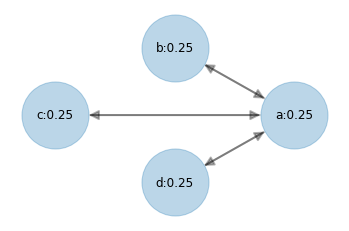

In [4]:
plot(G)

### Computing counts (i.e., number of unique links)
Counts is the out-degree of each node

In [5]:
counts={} # number of unique links going out of each node
for n in G.nodes():
    counts[n] = 0
for u,v in G.edges():
    if u not in counts:
        counts[u] = 0
    counts[u] += 1
pd.Series(counts)

a    3
b    1
c    1
d    1
dtype: int64

### Building a datastructure that contains all the links coming into a node
Each iteration of page rank, "people"/scores move between nodes. When we update a node, we need to know what nodes are linked to that node (i.e., reverse of following a link)

In [6]:
edges = {} # keep track of the links that are coming into a node
for n in G.nodes():
    edges[n] = []
for u,v in G.edges():
    edges[v].append(u) # reverse the order (edge is from u->v but our data structure is from v->u)
edges

{'a': ['b', 'c', 'd'], 'b': ['a'], 'c': ['a'], 'd': ['a']}

### Now perform one update (but with some problems)

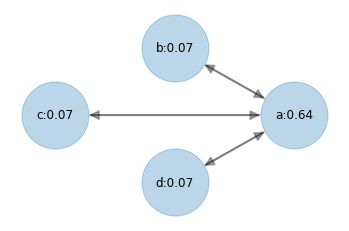

{'a': {'score': 0.6375},
 'b': {'score': 0.07083333333333333},
 'c': {'score': 0.07083333333333333},
 'd': {'score': 0.07083333333333333}}

In [7]:
d = 0.85 # define our decay
                
scores=dict((n,d['score']) for n,d in G.nodes(data=True))
attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))

for v in counts.keys():
    attrs[v]['score'] = 0
    for u in edges[v]:
        attrs[v]['score'] += d*scores[u]/counts[u]
nx.set_node_attributes(G, attrs)
plot(G)
attrs

**What is the problem with these scores? Do they sum to 1?**

In [8]:
s = 0
for u in attrs.keys():
    s += attrs[u]['score']
s

0.8499999999999999

**How do we fix this so they sum to 1?** Well. From each node we lost 0.85 because of the decay factor. Let's add that back in to all nodes!

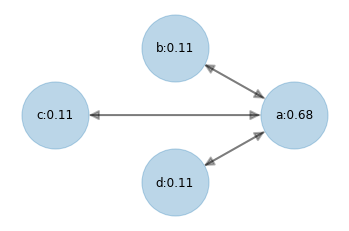

{'a': {'score': 0.675},
 'b': {'score': 0.10833333333333334},
 'c': {'score': 0.10833333333333334},
 'd': {'score': 0.10833333333333334}}

In [9]:
N = 4 # a,b,c,d ... example includes 4 webpages

# We are using networkx directed graph. 
G = nx.DiGraph()

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')

counts={} # number of unique links going out of each node
for n in G.nodes():
    counts[n] = 0
for u,v in G.edges():
    if u not in counts:
        counts[u] = 0
    counts[u] += 1

edges = {} # keep track of the links that are coming into a node
for n in G.nodes():
    edges[n] = []
for u,v in G.edges():
    edges[v].append(u) # reverse the order (edge is from u->v but our data structure is from v->u)

d = 0.85 # define our decay
                
scores=dict((n,d['score']) for n,d in G.nodes(data=True))
attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))

for v in counts.keys():
    attrs[v]['score'] = (1-d)/len(G.nodes())
    for u in edges[v]:
        attrs[v]['score'] += d*scores[u]/counts[u]
nx.set_node_attributes(G, attrs)
plot(G)
attrs

In [10]:
s = 0
for u in attrs.keys():
    s += attrs[u]['score']
s

1.0000000000000002

Looks good to me!

Here is some intuition. Remember, the score represents "the percentage of surfers present on the page". So, after iteration 1, about 67.5% percent of our web surfers are present on page A. Pages B, C, and D all have about 10.8333...% of the surfers each. This seems to roughly be what we want! If more surfers are on page A, then it's likely that it's a "more important page".

But did we miss anything else? Consider add a node that doesn't have any outlinks.

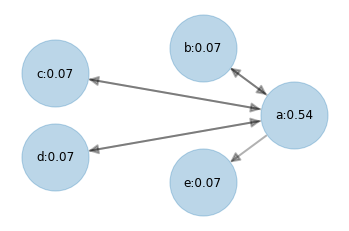

{'a': {'score': 0.54},
 'b': {'score': 0.07250000000000001},
 'c': {'score': 0.07250000000000001},
 'd': {'score': 0.07250000000000001},
 'e': {'score': 0.07250000000000001}}

In [11]:
N = 5 # a,b,c,d,e ... example includes 4 webpages

# We are using networkx directed graph. 
G = nx.DiGraph()

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)
G.add_node('e', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')
G.add_edge('a','e')

counts={} # number of unique links going out of each node
for n in G.nodes():
    counts[n] = 0
for u,v in G.edges():
    if u not in counts:
        counts[u] = 0
    counts[u] += 1

edges = {} # keep track of the links that are coming into a node
for n in G.nodes():
    edges[n] = []
for u,v in G.edges():
    edges[v].append(u) # reverse the order (edge is from u->v but our data structure is from v->u)

d = 0.85 # define our decay
                
scores=dict((n,d['score']) for n,d in G.nodes(data=True))
attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))

for v in counts.keys():
    attrs[v]['score'] = (1-d)/len(G.nodes())
    for u in edges[v]:
        attrs[v]['score'] += d*scores[u]/counts[u]
nx.set_node_attributes(G, attrs)
plot(G)
attrs

In [12]:
s = 0
for u in attrs.keys():
    s += attrs[u]['score']
s

0.8300000000000001

**What the heck?!** Did we just solve that problem? Well. This algorithm is all about movement with a decay, and so when the new node ``e`` is updated, we are losing its current visitors because it is a sink. The fix is in our original outline. We need to distribute the score at ``e`` to other nodes randomly.

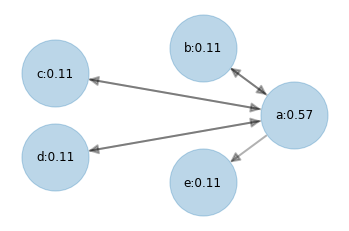

{'a': {'score': 0.5740000000000001},
 'b': {'score': 0.10650000000000001},
 'c': {'score': 0.10650000000000001},
 'd': {'score': 0.10650000000000001},
 'e': {'score': 0.10650000000000001}}

In [13]:
N = 5 # a,b,c,d,e ... example includes 4 webpages

# We are using networkx directed graph. 
G = nx.DiGraph()

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)
G.add_node('e', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')
G.add_edge('a','e')

counts={} # number of unique links going out of each node
for n in G.nodes():
    counts[n] = 0
for u,v in G.edges():
    if u not in counts:
        counts[u] = 0
    counts[u] += 1
    
#########################################################
# new
counts_series = pd.Series(counts)
sinks = list(counts_series.index[counts_series == 0])
#########################################################

edges = {} # keep track of the links that are coming into a node
for n in G.nodes():
    edges[n] = []
for u,v in G.edges():
    edges[v].append(u) # reverse the order (edge is from u->v but our data structure is from v->u)

d = 0.85 # define our decay
                
scores=dict((n,d['score']) for n,d in G.nodes(data=True))
attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))

for v in counts.keys():
    attrs[v]['score'] = (1-d)/len(G.nodes())
    for u in edges[v]:
        attrs[v]['score'] += d*scores[u]/counts[u]

for u in sinks:
    for n in G.nodes():
        attrs[n]['score'] += d*scores[u]/len(G.nodes())
nx.set_node_attributes(G, attrs)
plot(G)
attrs

In [14]:
s = 0
for u in attrs.keys():
    s += attrs[u]['score']
s

1.0000000000000002

This is looking good, so let's put it in a function. A function that performs one iteration of page rank.

In [15]:
def one_iteration(G,d=0.85):
    counts={} # number of unique links going out of each node
    for n in G.nodes():
        counts[n] = 0
    for u,v in G.edges():
        if u not in counts:
            counts[u] = 0
        counts[u] += 1

    counts_series = pd.Series(counts)
    sinks = list(counts_series.index[counts_series == 0])

    edges = {} # keep track of the links that are coming into a node
    for n in G.nodes():
        edges[n] = []
    for u,v in G.edges():
        edges[v].append(u) # reverse the order (edge is from u->v but our data structure is from v->u)

    scores=dict((n,d['score']) for n,d in G.nodes(data=True))
    attrs=dict((n,{"score":d['score']}) for n,d in G.nodes(data=True))

    for v in counts.keys():
        attrs[v]['score'] = (1-d)/len(G.nodes())
        for u in edges[v]:
            attrs[v]['score'] += d*scores[u]/counts[u]

    for u in sinks:
        for n in G.nodes():
            attrs[n]['score'] += d*scores[u]/len(G.nodes())
    nx.set_node_attributes(G, attrs)

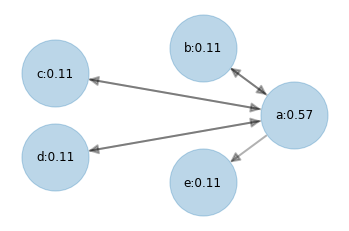

In [16]:
# Test it just once
G = nx.DiGraph()
N = 5

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)
G.add_node('e', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')
G.add_edge('a','e')

one_iteration(G)
plot(G)

## Stop and experiment
What do you think would have happened if we had increased or decreased $d$?

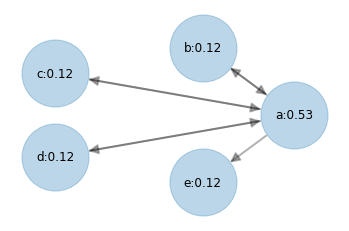

In [17]:
# Test it just once
G = nx.DiGraph()
N = 5

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)
G.add_node('e', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')
G.add_edge('a','e')

one_iteration(G,d=0.75)
plot(G)

**What can you say is happening when we change $d$? Do you think a lower or higher value is better?**

## Finishing our algorithm
If we go back to $d$ of 0.85, and we reinitialize our graph, then what happens as we run page run over multiple iterations?

### Initalize our graph again

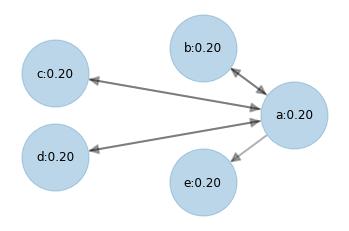

In [18]:
G = nx.DiGraph()
N = 5

# We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
G.add_node('a', score=1/N)
G.add_node('b', score=1/N)
G.add_node('c', score=1/N)
G.add_node('d', score=1/N)
G.add_node('e', score=1/N)

# We then create this specific example
G.add_edge('a', 'b')
G.add_edge('b', 'a')
G.add_edge('a', 'c')
G.add_edge('c', 'a')
G.add_edge('a', 'd')
G.add_edge('d', 'a')
G.add_edge('a','e')

plot(G)

### Run iteration 1 and plot

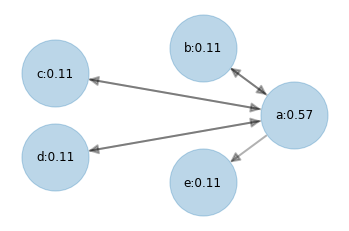

In [19]:
one_iteration(G)
plot(G)

### Update a second time

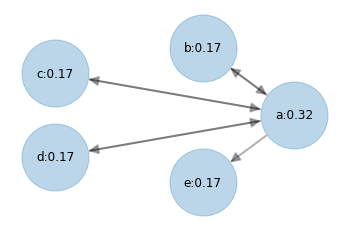

In [20]:
one_iteration(G)
plot(G)

Looking at the graph again the web surfers move again, page A now only has about 31.4% of the web surfers; pages B, C, and D all have about 22.88% each.

### A third time

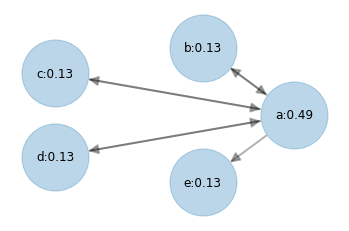

In [21]:
one_iteration(G)
plot(G)

### A fourth time

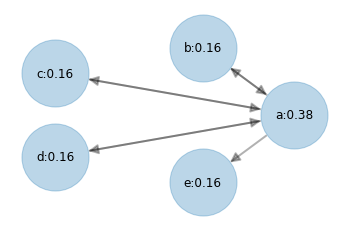

In [22]:
one_iteration(G)
plot(G)

### A fifth time

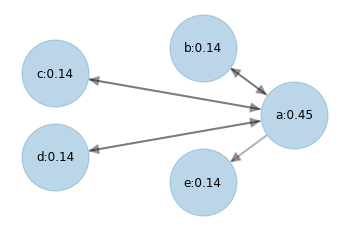

In [23]:
one_iteration(G)
plot(G)

### A sixth time

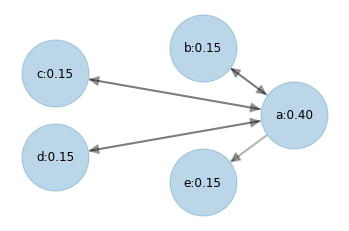

In [24]:
one_iteration(G)
plot(G)

What you can see is that we are starting to converge (i.e., we are being pulled together). $d$ has a direct affect on how fast we converge. But too high of $d$ and we might not converge correctly. Let's create a graphic that shows how the scores change as the number of iterations change.

In [25]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [26]:
@interact
def return_plot(iterations=(1,20,1)):
    G = nx.DiGraph()
    N = 5

    # We first add the nodes each with a page rank score of 1/N (i.e., all scores sum to 1)
    G.add_node('a', score=1/N)
    G.add_node('b', score=1/N)
    G.add_node('c', score=1/N)
    G.add_node('d', score=1/N)
    G.add_node('e', score=1/N)

    # We then create this specific example
    G.add_edge('a', 'b')
    G.add_edge('b', 'a')
    G.add_edge('a', 'c')
    G.add_edge('c', 'a')
    G.add_edge('a', 'd')
    G.add_edge('d', 'a')
    G.add_edge('a','e')

    for iteration in range(iterations):
        one_iteration(G)
    return plot(G)

interactive(children=(IntSlider(value=10, description='iterations', max=20, min=1), Output()), _dom_classes=('…

## Another example (cycle)

In [27]:
@interact
def return_plot(iterations=(1,20,1)):
    G = nx.DiGraph()
    N=3
    G.add_node('a', score=1/N)
    G.add_node('b', score=1/N)
    G.add_node('c', score=1/N)

    G.add_edge('a', 'b')
    G.add_edge('b', 'c')
    G.add_edge('c', 'a')

    for iteration in range(iterations):
        one_iteration(G)
    return plot(G)

interactive(children=(IntSlider(value=10, description='iterations', max=20, min=1), Output()), _dom_classes=('…

## Stop and question
Why does changing the number of iterations have no effect?

**Final thoughts:** There are many many improvements that could be made to the algorithm above, but the intuition behind those different algorithms is the same :)